# Rising Food Prices and Poverty in Latin America and the Caribbean:
## Effect of Ukrainian invasion

_Lina Arias, Laura Goyeneche; Roberto Sanchez; Luis Tejerina; Eric Torres_

### Index 

1. <a href = "#int" >Introduction</a>
2. <a href = "#met" >Methodology</a>
3. <a href = "#dat" >Data Preparation</a>
4. <a href = "#sta" >Poverty rates</a>
5. <a href = "#sen" >Poverty rates simulation</a>
6. <a href = "#con" >Conclusion</a>
7. <a href = "#ref" >References</a>

## <a id = "int">Introduction</a>

TEXTO

### Library

In [1]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
%%capture
%matplotlib inline
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Working directory

In [4]:
## Working directory
scldatalake = "s3://cf-p-scldata-prod-s3-p-scldata-app"

# Harmonized data
harmonized  = "Household Socio-Economic Surveys/Harmonized Household Surveys"

# Poverty lines 
povertyline = "Data Projects/International Poverty Lines/international_poverty_lines.csv"
pl          = pd.read_csv(f'{scldatalake}/{povertyline}')

### Data Preparation

#### Harmonized HH Surveys

In [5]:
hh = pd.read_csv(f'{scldatalake}/{harmonized}/concat/harmonized-latest-v3.csv')

/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
hh.columns

Index(['region_BID_c', 'region_c', 'pais_c', 'anio_c', 'mes_c', 'zona_c',
       'factor_ch', 'upm_ci', 'estrato_ci', 'idh_ch',
       ...
       'ysegmento_ci', 'lpe_ci.1', 'ytot_ci', 'ytot_ch', 'ytot_ci_ofi',
       'pc_ytot_ch_ofi', 'poor', 'poor31', 'poor_national', 'poor_e_national'],
      dtype='object', length=172)

In [ ]:
%%capture

# Define import method
option = 1 

# Calculate HH income
if option == 1:
    # Import data 
    hh = pd.read_csv(f'{scldatalake}/{harmonized}/concat/harmonized-latest-v3.csv')
    hh.columns = [i.strip() for i in hh.columns]
    
    # Generate HH income
    ytot_ci_vars  = ['ylm_ci','ylnm_ci','ynlm_ci','ynlnm_ci']
    hh['ytot_ci'] = hh.loc[hh.miembros_ci == 1, ytot_ci_vars].sum(axis = 1)
    hh['ytot_ch'] = hh.loc[hh.miembros_ci == 1,].groupby(['idh_ch','pais_c']).ytot_ci.transform(sum)
    hh.loc[hh.ytot_ch < 0,'ytot_ch'] = np.nan
    hh['pc_ytot_ch'] = hh.ytot_ch / hh.nmiembros_ch
    
    # Principal activities
    hh['sec_agri']   = np.where(((hh['categopri_ci'] == 1) | (hh['categopri_ci'] == 2)) & ((hh['rama_ci'] == 1) 
                                                                                           #| (hh['ramasec_ci'] == 1)
                                                                                          )  , 1, 0)
    hh['sec_transp'] = np.where(((hh['categopri_ci'] == 1) | (hh['categopri_ci'] == 2)) & ((hh['rama_ci'] == 7) 
                                                                                           #| (hh['ramasec_ci'] == 7)
                                                                                          )  , 1, 0)
    
    # Select variables of interest
    hh = hh[['pais_c','anio_c','mes_c','factor_ch','idh_ch','ytot_ch','pc_ytot_ch','sec_agri','sec_transp']]
    
else: 
    hh = []
    for year in range(2010,2021)[::-1]:      
        # Import data
        data = pd.read_csv(f'{scldatalake}/{harmonized}/concat/csv/harmonized-{year}.csv')

        # HH income 
        ytot_ci_vars    = ['ylm_ci','ylnm_ci','ynlm_ci','ynlnm_ci']
        data['ytot_ci'] = data.loc[data.miembros_ci == 1, ytot_ci_vars].sum(axis = 1)
        data['ytot_ch'] = data.loc[data.miembros_ci == 1,].groupby(['idh_ch','pais_c']).ytot_ci.transform(sum)
        data.loc[data.ytot_ch < 0,'ytot_ch'] = np.nan
        data['pc_ytot_ch'] = data.ytot_ch / data.nmiembros_ch
        
        # Select variables of interest
        data = data[['pais_c','anio_c','mes_c','factor_ch','idh_ch','ytot_ch','pc_ytot_ch']]

        # Append to master list
        hh.append(data)
        
    # Create dataframe
    hh = pd.concat(hh)

    # Keep most recent data 
    hh['recent_'] = hh.groupby('pais_c').anio_c.transform(max)
    hh = hh[hh.anio_c == hh.recent_]
    hh = hh.drop(columns = 'recent_')

In [5]:
# Countries included
print('Number of countries: ',hh.pais_c.unique().shape[0])
print(hh.pais_c.unique().tolist())

Number of countries:  25
['ARG', 'BHS', 'BLZ', 'BOL', 'BRA', 'BRB', 'CHL', 'COL', 'CRI', 'DOM', 'ECU', 'GTM', 'GUY', 'HND', 'JAM', 'MEX', 'NIC', 'PAN', 'PER', 'PRY', 'SLV', 'SUR', 'TTO', 'URY', 'VEN']


#### Validacion MEX

In [73]:
# Import data
%%capture
hh_ = pd.read_stata(f'{scldatalake}/{harmonized}/MEX/ENIGH/data_arm/MEX_2020v2_BID.dta')

In [115]:
# Calcular variable de ingresos
ytot_ci_vars  = [i for i in hh_.columns if 'ing_' in i]
ytot_ci_vars  = ['ing_lab']
hh_['ytot_ci'] = hh_.loc[hh_.miembros_ci == 1, ytot_ci_vars].sum(axis = 1)
hh_['ytot_ch'] = hh_.loc[hh_.miembros_ci == 1,].groupby(['idh_ch','pais_c']).ytot_ci.transform(sum)
hh_.loc[hh_.ytot_ch < 0,'ytot_ch'] = np.nan
hh_['pc_ytot_ch'] = hh_.ytot_ch / hh_.nmiembros_ch

In [116]:
# Tasa de pobreza
((((hh_.pc_ytot_ch < pl[pl.pais_c == 'MEX'].lp5_2011.item()).astype(int) * hh_.factor_ch).sum()) * 100 ) / hh_.factor_ch.sum()

12.342793740679694

In [117]:
# Principal activities
hh_['sec_agri']   = np.where(((hh_['categopri_ci'] == "Patron") | (hh_['categopri_ci'] == "Cuenta propia")) & ((hh_['rama_ci'] == "Agricultura, caza, silvicultura y pesca")), 1, 0)
hh_['sec_agri_2'] = np.where(((hh_['categosec_ci'] == "Patron") | (hh_['categosec_ci'] == "Cuenta propia")) & ((hh_['ramasec_ci'] == "Agricultura, caza, silvicultura y pesca")), 1, 0)
hh_['sec_agri']   = ((hh_.sec_agri + hh_.sec_agri_2) > 0).astype(int)

In [118]:
# Select variables of interest
hh__ = hh_[['pais_c','anio_c','factor_ch','idh_ch','ytot_ch','pc_ytot_ch','sec_agri','sec_agri_2']]

#### Poverty lines

In [9]:
# Reshape long to wide 
index = ['year','isoalpha3']
pl = pl.pivot(index = index, columns = 'indicator', values = 'value')
pl = pl.reset_index()
pl = pl.drop(columns = ['ppp_wdi2011','tc_wdi'])
pl = pl.rename(columns = {'isoalpha3':'code'})

# CPI 2011 = 100
pl['cpi_2011' ] = [pl[(pl.code == x) & (pl.year == 2011)].cpi.item() for x in pl.code]

# Keep most recent year
pl = pl[pl.year == 2020]

# Rename variables for merge 
pl.rename(columns = {'code':'pais_c'}, inplace = True)

In [15]:
pl.head()

indicator,year,pais_c,cpi,cpi_2011,lp19_2011,lp31_2011,lp5_2011,ppp_2011,lp_nat
806,2020,ARG,6.192070e+02,7.143000e+01,1583.679900,2583.89890,4167.57860,3.161164,
807,2020,BHS,1.080700e+02,9.654600e+01,72.791206,118.76460,191.55580,1.125234,352.3
808,2020,BLZ,1.000000e+02,9.564200e+01,70.940338,115.74477,186.68510,1.174023,193.4
809,2020,BOL,1.044220e+02,7.664000e+01,227.642620,371.41690,599.05951,2.891025,
810,2020,BRA,3.550000e+13,2.190000e+13,154.612950,252.26324,406.87619,1.651221,450


In [19]:
# Temporal
# Add official poverty lines 
temp_ = {'BHS':352.3,'BLZ':193.4,'BRA':450,'CHL':174131,'COL':369521.2,'CRI':99352.5,'CRI':101485,'DOM':5329.3,'GTM':851.5,'HND':2701.2,'JAM':110956.7,'MEX':3040,'NIC':707.2,'PAN':129.7,'SLV':88.3,'SUR':618.9,'TTO':421.3}
pl['lp_nat'] = pl.pais_c.replace(temp_)
pl.lp_nat = np.where(pl.lp_nat == pl.pais_c,np.nan,pl.lp_nat)

In [20]:
tasas = hh.merge(pl[['pais_c','lp_nat']], on = 'pais_c', how = 'left')

In [21]:
tasas['poor05_net'] = (tasas.pc_ytot_ch < tasas.lp_nat).astype(int) * tasas.factor_ch

In [23]:
tasas = tasas.groupby(['pais_c','anio_c'])[['poor05_net','lp_nat','factor_ch']].sum()
tasas = tasas.reset_index()

In [24]:
tasas['poor05_net'] = (tasas['poor05_net'] / tasas.factor_ch) * 100 

In [26]:
tasas[tasas.poor05_net > 0]

,pais_c,anio_c,poor05_net,factor_ch
1,BHS,2014.0,21.487088,1.977907e+05
2,BLZ,2007.0,29.533957,3.139237e+05
4,BRA,2020.0,24.071303,2.110965e+08
6,CHL,2020.0,44.931225,1.954580e+07
7,COL,2020.0,50.437928,4.962024e+07
8,CRI,2021.0,33.870581,5.163413e+06
9,DOM,2020.0,37.770946,1.048096e+07
11,GTM,2019.0,58.695325,1.755321e+07
13,HND,2019.0,64.270571,2.251019e+06
14,JAM,2018.0,79.668642,3.157965e+06


### International Poverty Lines Function

In [61]:
# Poverty lines calculation
def int_lp(hh, data, w, c):
    # Create copy
    data_ = data.copy()
    hh_   = hh.copy()
    
    # Changes in CPI
    data_['cpi_hat'] = data_.cpi * w * (1 + c) + data_.cpi * (1 - w)
        
    # CPI 2011 = 100
    data_['cpi_ratio'] = data_.cpi_hat / data_.cpi_2011
    
    # Poverty lines 
    # Changes in CPI 
    data_['lp19_2011'] = (1.9*(365/12)) * data_.cpi_ratio * data_.ppp_2011
    data_['lp31_2011'] = (3.1*(365/12)) * data_.cpi_ratio * data_.ppp_2011
    data_['lp05_2011'] = (5.0*(365/12)) * data_.cpi_ratio * data_.ppp_2011

    # Changes in PL 
    data_['lp19_2011_'] = ((1.9*(365/12)) * (data_.cpi / data_.cpi_2011) * data_.ppp_2011) * (1 + c)
    data_['lp31_2011_'] = ((3.1*(365/12)) * (data_.cpi / data_.cpi_2011) * data_.ppp_2011) * (1 + c)
    data_['lp05_2011_'] = ((5.0*(365/12)) * (data_.cpi / data_.cpi_2011) * data_.ppp_2011) * (1 + c)
    
    # Identify poverty lines vars
    lp_vars = [name for name in data_.columns if 'lp' in name]
    
    # Adjust for changes in Venezuelan currency
    for name in lp_vars:
        data_.loc[data_.pais_c == 'VEN',name] = data_.loc[data_.pais_c == 'VEN',name] / 100000000
    
    # Merge with HH 
    tasas = hh_.merge(data_, on = 'pais_c', how = 'left')
    
    # Replace Nas in factor_ch
    tasas.factor_ch = tasas.factor_ch.fillna(1)
    
    # Calculate poor indicator
    # Changes in CPI
    tasas['poor19'] = (tasas.pc_ytot_ch < tasas.lp19_2011).astype(int) * tasas.factor_ch
    tasas['poor31'] = (tasas.pc_ytot_ch < tasas.lp31_2011).astype(int) * tasas.factor_ch
    tasas['poor05'] = (tasas.pc_ytot_ch < tasas.lp05_2011).astype(int) * tasas.factor_ch
    
    # Changes in LP
    tasas['poor19_'] = (tasas.pc_ytot_ch < tasas.lp19_2011_).astype(int) * tasas.factor_ch
    tasas['poor31_'] = (tasas.pc_ytot_ch < tasas.lp31_2011_).astype(int) * tasas.factor_ch
    tasas['poor05_'] = (tasas.pc_ytot_ch < tasas.lp05_2011_).astype(int) * tasas.factor_ch
    
    # Changes in income: agriculture and transportation
    tasas['pc_ytot_ch_adj'] = np.where(tasas.sec_agri == 1, tasas.pc_ytot_ch * (1 + w), tasas.pc_ytot_ch)
    tasas['poor19_net'] = (tasas.pc_ytot_ch_adj < tasas.lp19_2011_).astype(int) * tasas.factor_ch
    tasas['poor31_net'] = (tasas.pc_ytot_ch_adj < tasas.lp31_2011_).astype(int) * tasas.factor_ch
    tasas['poor05_net'] = (tasas.pc_ytot_ch_adj < tasas.lp05_2011_).astype(int) * tasas.factor_ch
    
    # Identify poverty rates vars
    poor_vars = [name for name in tasas.columns if 'poor' in name]
    
    # Replace NA values
    for name in poor_vars:
        tasas[name].fillna(0, inplace = True)
    
    # Temporary count
    tasas['n_temp'] = 1
    
    # Results
    tasas = tasas.groupby(['pais_c','anio_c'])[poor_vars + lp_vars + ['factor_ch','n_temp']].sum()
    tasas = tasas.reset_index()
    # LAC: tasas = pd.DataFrame(tasas[poor_vars + lp_vars + ['factor_ch','n_temp']].sum()).T
    
    # Calculate % poor
    for name in poor_vars:
        tasas[f'{name}_n'] = tasas[name]
        tasas[name] = (tasas[name] / tasas.factor_ch) * 100 

    # Add variables
    tasas['weight'] = w*100
    tasas['change'] = c*100
    
    return tasas

### Simulation

In [8]:
%%capture

# Run multiple scenarios
weight = [i/100 for i in range(0,65,5)]
change = [i/100 for i in range(0,65,5) ]
final  = []
for i in weight:
    for j in change:
        final.append(int_lp(hh,pl,i,j))

# Master table
final = pd.concat(final)

In [120]:
# Calculate changes in poverty 
for i in ['poor19','poor31','poor05']:
    final[f'{i}_baseline'] = [final[(final.pais_c == x) & (final.weight == 0) & (final.change == 0)][i].item() for x in final.pais_c]
    final[f'{i}_pp']       = final[i]          - final[f'{i}_baseline']
    final[f'{i}_pp_']      = final[f'{i}_']    - final[f'{i}_baseline']
    final[f'{i}_pp_net']   = final[f'{i}_net'] - final[f'{i}_baseline']

In [10]:
# Export results
option = 0
if option == 1{
    final.to_csv('simulation-results.csv', index = False)
}

In [121]:
final[(final.weight >= 0) & (final.change >= 0)][['pais_c','poor05_','poor05_net','poor05_baseline','weight','change']]

,pais_c,poor05_,poor05_net,poor05_baseline,weight,change
0,MEX,12.342794,12.342794,12.342794,0.0,0.0
0,MEX,13.175974,13.175974,12.342794,0.0,10.0
0,MEX,13.904576,13.904576,12.342794,0.0,20.0
0,MEX,14.745674,14.745674,12.342794,0.0,30.0
0,MEX,12.342794,12.263492,12.342794,10.0,0.0
0,MEX,13.175974,13.087936,12.342794,10.0,10.0
0,MEX,13.904576,13.810793,12.342794,10.0,20.0
0,MEX,14.745674,14.632774,12.342794,10.0,30.0
0,MEX,12.342794,12.200803,12.342794,20.0,0.0
0,MEX,13.175974,13.016693,12.342794,20.0,10.0


#### Distribution of poverty rate changes in percentual points

In [ ]:
# Distribution in changes in poverty CPI
plt.figure(figsize = (15,5))
var = "poor05_pp"
ax = sns.boxplot(x = 'pais_c', y = var, data = final[(final.weight == 25) & (final.change > 0)])
plt.xlabel('')
plt.ylabel('')
plt.title('Poverty rate changes (percentual points)')
plt.show()

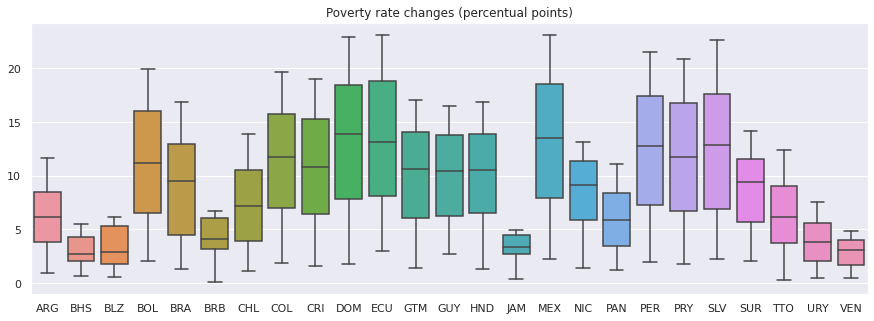

In [12]:
# Distribution in changes in PL
plt.figure(figsize = (15,5))
var = "poor05_pp_"
ax = sns.boxplot(x = 'pais_c', y = var, data = final[(final.weight == 0) & (final.change > 0)])
plt.xlabel('')
plt.ylabel('')
plt.title('Poverty rate changes (percentual points)')
plt.show()

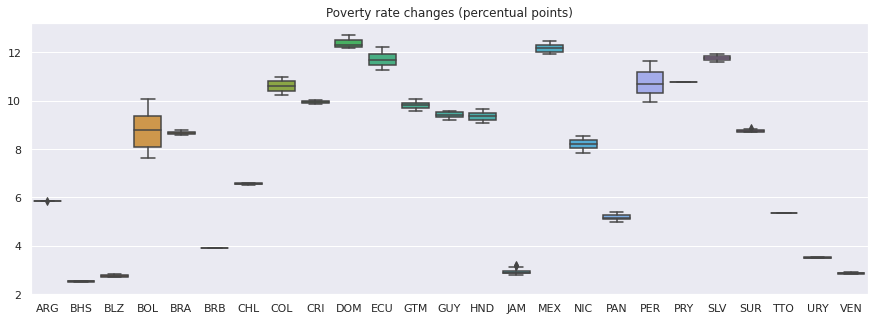

In [20]:
# Distribution in changes in PL net
plt.figure(figsize = (15,5))
var = "poor05_pp_net"
ax = sns.boxplot(x = 'pais_c', y = var, data = final[(final.weight > 0) & (final.change == 30)])
plt.xlabel('')
plt.ylabel('')
plt.title('Poverty rate changes (percentual points)')
plt.show()

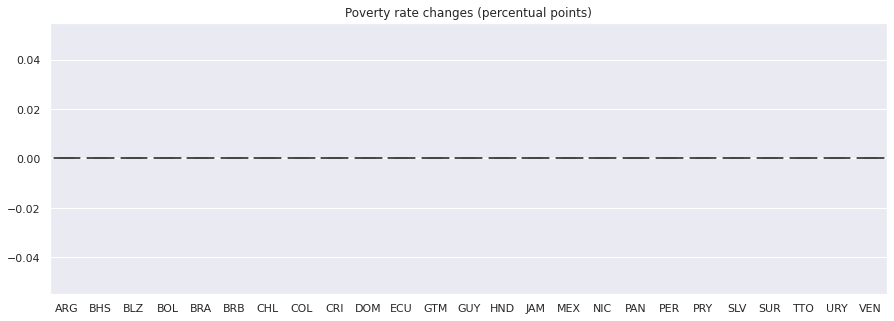

In [23]:
# Distribution of differences in changes PL and PL net 
# Difference
final['poor05_pp_diff'] = final.poor05_pp_ - final.poor05_pp_net

# Figure
plt.figure(figsize = (15,5))
var = "poor05_pp_diff"
ax = sns.boxplot(x = 'pais_c', y = var, data = final[(final.weight > 0) & (final.change > 0)])
plt.xlabel('')
plt.ylabel('')
plt.title('Poverty rate changes (percentual points)')
plt.show()

#### Distribution of poverty rate changes in percentual points by country

##### Changes in CPI

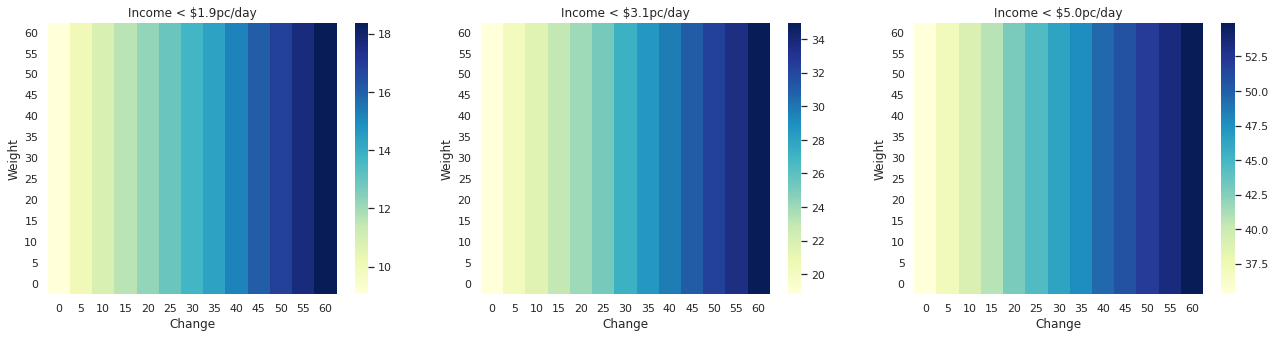

In [14]:
# Ejemplo para Colombia
# Data
temp = final.copy()
temp = temp.rename(columns = {'poor19_':'Income < $1.9pc/day','poor31_':'Income < $3.1pc/day','poor05_':'Income < $5.0pc/day'})
temp = temp[temp.pais_c == "COL"]
temp.weight = temp.weight.astype(int)
temp.change = temp.change.astype(int)

# Poverty level
colnames = [i for i in temp.columns if 'Income' in i]

# Figure by poverty level 
plt.figure(figsize = (22,5))

for i,name in enumerate(colnames):
    # Filter dataset
    temp_ = pd.pivot_table(temp, values = name, index = 'weight', columns = 'change')
    
    # Subplot
    plt.subplot(1,3,i+1)
    ax = sns.heatmap(temp_, cmap = "YlGnBu")
    
    # Names and labels
    plt.title(name)
    ax.invert_yaxis()
    plt.yticks(rotation = 0)
    plt.ylabel('Weight')
    plt.xlabel('Change')
    
plt.show()